# Boosting Revenue for an online store

 ## Contents <a id='back'></a>
 * [Introduction](#intro)
     * [Project Puropse](#project_puropse)
     * [Data Description](#data_description)
     * [Task decomposition](#data_transformation)
 * [Open the data file](#open_the_data_file)
     * [Data Quality Assessment](#data_quality_assessment)
 * [Prepare the data](#prepare_the_data)
     * [Replace the column names](#replace_the_column_names)
     * [Correcting data types](#correcting_data_types)
     * [Description of the columns](#description_of_the_columns)
     * [Address Missing Data](#address_missing_data)
 * [Analyze the data](#analyze_the_data)
 * [Test statistical hypotheses](#test_statistical_hypotheses)
 * [General conclution](#general_conclution)

## Introduction <a id='data_review'></a>

As an an analyst, together with the marketing department at a big online store have complieda list of hypotheses that may help boost
revenue.

### Project Puropse

Prioritize these hypotheses, launch an A/B test, and analyze theresults.


### Data Description

- Data used in the first part of the project `/datasets/hypotheses_us.csv`
    - `Hypotheses` — brief descriptions of the hypotheses
    - `Reach` — user reach, on a scale of one to ten
    - `Impact` — impact on users, on a scale of one to ten
    - `Confidence` — confidence in the hypothesis, on a scale of one to ten
    - `Effort` — the resources required to test a hypothesis, on a scale of one to ten. The higher the Effort value, the more resource-intensive the test.

- Data used in the second part of the project `/datasets/orders_us.csv`
    - `transactionId` — order identifier
    - `visitorId` — identifier of the user who placed the order
    - `date` — of the order
    - `revenue` — from the order
    - `group` — the A/B test group that the user belongs to

- `/datasets/visits_us.csv`
    - `date` — date
    - `group` — A/B test group
    - `visits` — the number of visits on the date specified in the A/B test group specified


    
### **Task decomposition:** <a id='data_review'></a>
- Part 1. Prioritizing Hypotheses
- Part 2. A/B Test Analysis

## Initialization

In [1]:
# Loading all the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import factorial
from scipy import stats as st
import scipy.stats as stats
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind

## Open the data file and study the general information

In [2]:
# Load the data file into a DataFrame
df_hypotheses = pd.read_csv('/datasets/hypotheses_us.csv', delimiter = ';')
df_order = pd.read_csv('/datasets/orders_us.csv')
df_visits = pd.read_csv('/datasets/visits_us.csv')

In [3]:
df_hypotheses

,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1
5,Add a customer review page. This will increase...,3,2,2,3
6,Show banners with current offers and sales on ...,5,3,8,3
7,Add a subscription form to all the main pages....,10,7,8,5
8,Launch a promotion that gives users discounts ...,1,9,9,5


In [4]:
df_order

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,100.8,B
1193,2203539145,370388673,2019-08-14,50.1,A
1194,1807773912,573423106,2019-08-14,165.3,A
1195,1947021204,1614305549,2019-08-14,5.5,A


In [5]:
# obtaining general information about the data in df
df_order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB


In [6]:
# Rename columns
df_order = df_order.rename(columns={
    'transactionId': 'transaction_id',
    'visitorId': 'visitor_id',
    'date': 'date',
    'revenue': 'revenue',
    'group': 'group'
})

df_order

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,100.8,B
1193,2203539145,370388673,2019-08-14,50.1,A
1194,1807773912,573423106,2019-08-14,165.3,A
1195,1947021204,1614305549,2019-08-14,5.5,A


In [7]:
# Counting clear duplicates in the DataFrame df_order
print('Duplications in DataFrame df_order:', df_order.duplicated().sum())

Duplications in DataFrame df_order: 0


In [8]:
# obtaining general information about the data in df
df_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [9]:
# Counting clear duplicates in the DataFrame df_visits
print('Duplications in DataFrame df_visits:', df_visits.duplicated().sum())

Duplications in DataFrame df_visits: 0


In [10]:
df_visits

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


In [11]:
# obtaining general information about the data in df
df_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


**Data Quality Assesment** 

The initial Data Quality Assesment indicated that the data does not contain blatant errors

### Part 1. Prioritizing Hypotheses

The file `hypotheses_us.csv` contains nine hypotheses on boosting an online store's revenue with `Reach` , `Impact` , `Confidence` , and `Effort` specified for each.

The task is to:

- Apply the `ICE` framework to prioritize hypotheses. Sort them indescending order of priority.
- Apply the `RICE` framework to prioritize hypotheses. Sort them in descending order of priority.
- Show how the prioritization of hypotheses changes when you use `RICE` instead of `ICE`. Provide an explanation for the changes.

In [12]:
df_hypotheses

,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1
5,Add a customer review page. This will increase...,3,2,2,3
6,Show banners with current offers and sales on ...,5,3,8,3
7,Add a subscription form to all the main pages....,10,7,8,5
8,Launch a promotion that gives users discounts ...,1,9,9,5


**Apply the ICE framework to prioritize hypotheses. Sort them indescending order of priority.**

- ICE Framework: ICE stands for Impact, Confidence, and Effort. To prioritize using ICE:


- Calculate ICE Score:
    - Impact: How much of an effect the hypothesis could have if implemented.
    - Confidence: Level of certainty that the impact will occur.
    - Effort: Resources required to implement the hypothesis.
    

- The formula for ICE score: **(Impact × Confidence) / Effort**

In [13]:
# Calculate ICE Score
df_hypotheses['ICE'] = (df_hypotheses['Impact'] * df_hypotheses['Confidence']) / df_hypotheses['Effort']
df_hypotheses

,Hypothesis,Reach,Impact,Confidence,Effort,ICE
0,Add two new channels for attracting traffic. T...,3,10,8,6,13.333333
1,Launch your own delivery service. This will sh...,2,5,4,10,2.000000
2,Add product recommendation blocks to the store...,8,3,7,3,7.000000
3,Change the category structure. This will incre...,8,3,3,8,1.125000
4,Change the background color on the main page. ...,3,1,1,1,1.000000
5,Add a customer review page. This will increase...,3,2,2,3,1.333333
6,Show banners with current offers and sales on ...,5,3,8,3,8.000000
7,Add a subscription form to all the main pages....,10,7,8,5,11.200000
8,Launch a promotion that gives users discounts ...,1,9,9,5,16.200000


In [14]:
# Sort by ICE Score in descending order
ice_sorted = df_hypotheses.sort_values(by='ICE', ascending=False)
ice_sorted

,Hypothesis,Reach,Impact,Confidence,Effort,ICE
8,Launch a promotion that gives users discounts ...,1,9,9,5,16.200000
0,Add two new channels for attracting traffic. T...,3,10,8,6,13.333333
7,Add a subscription form to all the main pages....,10,7,8,5,11.200000
6,Show banners with current offers and sales on ...,5,3,8,3,8.000000
2,Add product recommendation blocks to the store...,8,3,7,3,7.000000
1,Launch your own delivery service. This will sh...,2,5,4,10,2.000000
5,Add a customer review page. This will increase...,3,2,2,3,1.333333
3,Change the category structure. This will incre...,8,3,3,8,1.125000
4,Change the background color on the main page. ...,3,1,1,1,1.000000


**Apply the RICE framework to prioritize hypotheses. Sort them in descending order of priority.**

- RICE Framework:
    - RICE adds another factor, Reach, to the ICE framework.
    - RICE stands for Reach, Impact, Confidence, and Effort. To prioritize using RICE:

- Calculate RICE Score:
    - Reach: How many users or customers the change will affect.
    - Impact: Similar to ICE, the magnitude of the effect.
    - Confidence: The certainty that the impact will occur.
    - Effort: Resources required to implement the hypothesis.

- The formula for RICE score: **(Reach × Impact × Confidence) / Effort**

In [15]:
# Calculate RICE Score
df_hypotheses['RICE'] = (df_hypotheses['Reach'] * df_hypotheses['Impact'] * df_hypotheses['Confidence']) / df_hypotheses['Effort']

df_hypotheses

,Hypothesis,Reach,Impact,Confidence,Effort,ICE,RICE
0,Add two new channels for attracting traffic. T...,3,10,8,6,13.333333,40.0
1,Launch your own delivery service. This will sh...,2,5,4,10,2.000000,4.0
2,Add product recommendation blocks to the store...,8,3,7,3,7.000000,56.0
3,Change the category structure. This will incre...,8,3,3,8,1.125000,9.0
4,Change the background color on the main page. ...,3,1,1,1,1.000000,3.0
5,Add a customer review page. This will increase...,3,2,2,3,1.333333,4.0
6,Show banners with current offers and sales on ...,5,3,8,3,8.000000,40.0
7,Add a subscription form to all the main pages....,10,7,8,5,11.200000,112.0
8,Launch a promotion that gives users discounts ...,1,9,9,5,16.200000,16.2


In [16]:
# Sort by RICE Score in descending order
rice_sorted = df_hypotheses.sort_values(by='RICE', ascending=False)
rice_sorted

,Hypothesis,Reach,Impact,Confidence,Effort,ICE,RICE
7,Add a subscription form to all the main pages....,10,7,8,5,11.200000,112.0
2,Add product recommendation blocks to the store...,8,3,7,3,7.000000,56.0
0,Add two new channels for attracting traffic. T...,3,10,8,6,13.333333,40.0
6,Show banners with current offers and sales on ...,5,3,8,3,8.000000,40.0
8,Launch a promotion that gives users discounts ...,1,9,9,5,16.200000,16.2
3,Change the category structure. This will incre...,8,3,3,8,1.125000,9.0
1,Launch your own delivery service. This will sh...,2,5,4,10,2.000000,4.0
5,Add a customer review page. This will increase...,3,2,2,3,1.333333,4.0
4,Change the background color on the main page. ...,3,1,1,1,1.000000,3.0


**Show how the prioritization of hypotheses changes when you use RICE instead of ICE. Provide an explanation for the changes.**

In [17]:
rice_sorted

,Hypothesis,Reach,Impact,Confidence,Effort,ICE,RICE
7,Add a subscription form to all the main pages....,10,7,8,5,11.200000,112.0
2,Add product recommendation blocks to the store...,8,3,7,3,7.000000,56.0
0,Add two new channels for attracting traffic. T...,3,10,8,6,13.333333,40.0
6,Show banners with current offers and sales on ...,5,3,8,3,8.000000,40.0
8,Launch a promotion that gives users discounts ...,1,9,9,5,16.200000,16.2
3,Change the category structure. This will incre...,8,3,3,8,1.125000,9.0
1,Launch your own delivery service. This will sh...,2,5,4,10,2.000000,4.0
5,Add a customer review page. This will increase...,3,2,2,3,1.333333,4.0
4,Change the background color on the main page. ...,3,1,1,1,1.000000,3.0


In [18]:
print("ICE prioritization:")
display(ice_sorted[['Hypothesis', 'ICE']])
print("\nRICE prioritization:")
display(rice_sorted[['Hypothesis', 'RICE']])

ICE prioritization:


,Hypothesis,ICE
8,Launch a promotion that gives users discounts ...,16.200000
0,Add two new channels for attracting traffic. T...,13.333333
7,Add a subscription form to all the main pages....,11.200000
6,Show banners with current offers and sales on ...,8.000000
2,Add product recommendation blocks to the store...,7.000000
1,Launch your own delivery service. This will sh...,2.000000
5,Add a customer review page. This will increase...,1.333333
3,Change the category structure. This will incre...,1.125000
4,Change the background color on the main page. ...,1.000000



RICE prioritization:


,Hypothesis,RICE
7,Add a subscription form to all the main pages....,112.0
2,Add product recommendation blocks to the store...,56.0
0,Add two new channels for attracting traffic. T...,40.0
6,Show banners with current offers and sales on ...,40.0
8,Launch a promotion that gives users discounts ...,16.2
3,Change the category structure. This will incre...,9.0
1,Launch your own delivery service. This will sh...,4.0
5,Add a customer review page. This will increase...,4.0
4,Change the background color on the main page. ...,3.0


In [19]:
# Unique valuews in 'Hypothesis'columns
unique_values_1 = ice_sorted['Hypothesis'].unique()
unique_values_2 = rice_sorted['Hypothesis'].unique()

# Print the unique values
print(unique_values_1)
print()
print(unique_values_2)

['Launch a promotion that gives users discounts on their birthdays'
 'Add two new channels for attracting traffic. This will bring 30% more users'
 'Add a subscription form to all the main pages. This will help you compile a mailing list'
 'Show banners with current offers and sales on the main page. This will boost conversion'
 "Add product recommendation blocks to the store's site. This will increase conversion and average purchase size"
 'Launch your own delivery service. This will shorten delivery time'
 'Add a customer review page. This will increase the number of orders'
 'Change the category structure. This will increase conversion since users will find the products they want more quickly'
 'Change the background color on the main page. This will increase user engagement']

['Add a subscription form to all the main pages. This will help you compile a mailing list'
 "Add product recommendation blocks to the store's site. This will increase conversion and average purchase size"
 '

**General Conclution**

When `RICE` is used the reach of each Hypothesis is considered. With reach the number of users/customers affected by the change.

**ICE prioritization:**
- Launch a promotion that gives users discounts on their birthdays
- Add two new channels for attracting traffic. This will bring 30% more users
- Add a subscription form to all the main pages. This will help you compile a mailing list
- Show banners with current offers and sales on the main page. This will boost conversion
- Add product recommendation blocks to the store's site. This will increase conversion and average purchase size
- Launch your own delivery service. This will shorten delivery time
- Add a customer review page. This will increase the number of orders
- Change the category structure. This will increase conversion since users will find the products they want more quickly
- Change the background color on the main page. This will increase user engagement

**RICE prioritization:**
- Add a subscription form to all the main pages. This will help you compile a mailing list
- Add product recommendation blocks to the store's site. This will increase conversion and average purchase size
- Add two new channels for attracting traffic. This will bring 30% more users
- Show banners with current offers and sales on the main page. This will boost conversion
- Launch a promotion that gives users discounts on their birthdays
- Change the category structure. This will increase conversion since users will find the products they want more quickly
- Launch your own delivery service. This will shorten delivery time
- Add a customer review page. This will increase the number of orders
- Change the background color on the main page. This will increase user engagement

### Part 2. A/B Test Analysis

Carried out an A/B test and got the results described in the files
`orders_us.csv` and `visits_us.csv`.

An A/B test is used to compare two variations of a thing. 

**Task:**
Analyze the A/B test:
1.  Graph cumulative revenue by group. Make conclusions and conjectures.
2. Graph cumulative average order size by group. Make conclusions and conjectures.
3. Graph the relative difference in cumulative average order size for group B compared with group A. Make conclusions and conjectures.
4. Calculate each group's conversion rate as the ratio of orders to the number of visits for each day. Plot the daily conversion rates of the two groups and describe the difference. Draw conclusions and make conjectures.
5. Plot a scatter chart of the number of orders per user. Make conclusionsand conjectures.
6. Calculate the 95th and 99th percentiles for the number of orders per user. Define the point at which a data point becomes an anomaly.
7. Plot a scatter chart of order prices. Make conclusions and conjectures.
8. Calculate the 95th and 99th percentiles of order prices. Define the point at which a data point becomes an anomaly.
9.  Find the statistical significance of the difference in conversion between the groups using the raw data. Make conclusions and conjectures.
10. Find the statistical significance of the difference in average order size between the groups using the raw data. Make conclusions and conjectures.
11. Find the statistical significance of the difference in conversion between the groups using the filtered data. Make conclusions and conjectures.
12.  Find the statistical significance of the difference in average order size between the groups using the filtered data. Make conclusions and conjectures.
13.  Make a decision based on the test results. The possible decisions are:
    - 1. Stop the test, consider one of the groups the leader.
    - 2. Stop the test, conclude that there is no difference between the groups.
    - 3. Continue the test.

In [20]:
print('Dataframe: df_order')
display(df_order)

print('\nDataframe: df_visits')
display(df_visits)

Dataframe: df_order


,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,100.8,B
1193,2203539145,370388673,2019-08-14,50.1,A
1194,1807773912,573423106,2019-08-14,165.3,A
1195,1947021204,1614305549,2019-08-14,5.5,A



Dataframe: df_visits


,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


#### Graph cumulative revenue by group.

In [21]:
# df_order
# Calculate cumulative revenue by group
df_cumulative = df_order.groupby(['date', 'group'])['revenue'].sum().groupby('group').cumsum().reset_index()

# Pivot the data for plotting
pivot_df = df_cumulative.pivot(index='date', columns='group', values='revenue')

display(df_cumulative)
display(pivot_df)

,date,group,revenue
0,2019-08-01,A,2356.8
1,2019-08-01,B,1620.0
2,2019-08-02,A,3860.3
3,2019-08-02,B,4243.8
4,2019-08-03,A,5675.5
...,...,...,...
57,2019-08-29,B,87343.0
58,2019-08-30,A,63563.5
59,2019-08-30,B,90736.3
60,2019-08-31,A,64554.9


group,A,B
date,,
2019-08-01,2356.8,1620.0
2019-08-02,3860.3,4243.8
2019-08-03,5675.5,6050.6
2019-08-04,6822.1,7767.9
2019-08-05,8810.2,9262.9
2019-08-06,9600.0,13069.3
2019-08-07,11842.9,16600.8
2019-08-08,13373.3,20088.6
2019-08-09,16320.4,22646.7


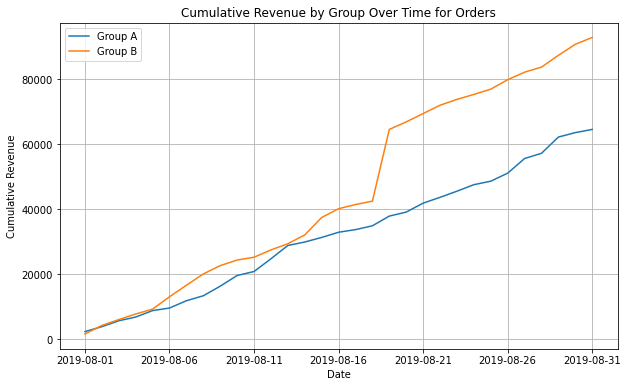

In [22]:
# Set a step size for displaying date labels
step_size = 5
date_labels = pivot_df.index[::step_size]

# Plotting the cumulative revenue by group
plt.figure(figsize=(10, 6))
plt.plot(pivot_df.index, pivot_df['A'], label='Group A')
plt.plot(pivot_df.index, pivot_df['B'], label='Group B')
plt.xlabel('Date')
plt.ylabel('Cumulative Revenue')
plt.title('Cumulative Revenue by Group Over Time for Orders')
plt.legend()
plt.grid(True)

# Set x-axis ticks
plt.xticks(date_labels)

plt.show()

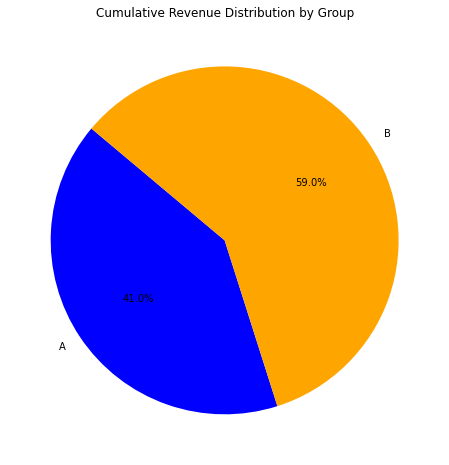

In [23]:
labels = df_cumulative['group'].unique()
values = df_cumulative.groupby('group')['revenue'].max()

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140, colors=['blue', 'orange'])
plt.title('Cumulative Revenue Distribution by Group')
plt.show()

In [24]:
# Calculate the cumulative revenue for the groups
total_cumulative_revenue = df_cumulative.groupby('group')['revenue'].max().reset_index()

print(total_cumulative_revenue)

  group  revenue
0     A  64554.9
1     B  92840.6


##### Conclusions and conjectures.

- Group B has a higher cumulative revenue than Group A from the beginning to the end period (2019-08-01 to 2019-08-31)
- Group B has a  performs better than Group A, with 92840.6 units accounting for 59% of the total revenue and 64554.9 units accounting for 41% of the total revenue for the two groups respectively

#### Graph cumulative average order size by group.

In [25]:
# Convert 'date' column to datetime format
df_order['date'] = pd.to_datetime(df_order['date'])

# Sort values by date
df_order.sort_values('date', inplace=True)

# Calculate cumulative sum of revenue and count of transactions by group
df_order['cumulative_revenue'] = df_order.groupby('group')['revenue'].cumsum()
df_order['cumulative_orders'] = df_order.groupby('group').cumcount() + 1  # Adding 1 to start count from 1

# Calculate cumulative average order size by group
df_order['cumulative_avg_order_size'] = df_order['cumulative_revenue'] / df_order['cumulative_orders']

In [26]:
group_cumulative_avg_order_size = df_order.groupby('group')['cumulative_avg_order_size'].max().reset_index()

print(group_cumulative_avg_order_size)

  group  cumulative_avg_order_size
0     A                      243.1
1     B                      165.7


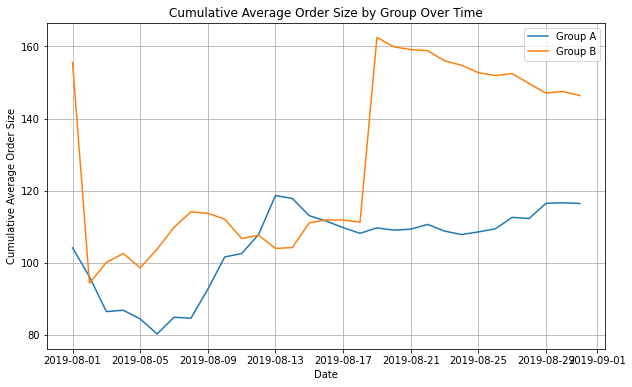

In [27]:
# Convert 'date' column to datetime format
df_order['date'] = pd.to_datetime(df_order['date'])

# Sort values by date
df_order.sort_values('date', inplace=True)

# Calculate cumulative sum of revenue and count of transactions by group
df_order['cumulative_revenue'] = df_order.groupby('group')['revenue'].cumsum()
df_order['cumulative_orders'] = df_order.groupby('group').cumcount() + 1  # Adding 1 to start count from 1

# Calculate cumulative average order size by group
df_order['cumulative_avg_order_size'] = df_order['cumulative_revenue'] / df_order['cumulative_orders']

# Aggregate the data by date and remove duplicates
aggregated_data = df_order.groupby(['date', 'group'])['cumulative_avg_order_size'].max().unstack()

# Plotting the cumulative average order size by group
plt.figure(figsize=(10, 6))
plt.plot(aggregated_data.index, aggregated_data['A'], label='Group A')
plt.plot(aggregated_data.index, aggregated_data['B'], label='Group B')
plt.xlabel('Date')
plt.ylabel('Cumulative Average Order Size')
plt.title('Cumulative Average Order Size by Group Over Time')
plt.legend()
plt.grid(True)
plt.show()

##### Conclusions and conjectures.

- The orders for both groups carry a similar shape
- The Cumulative Average Order Size is the highest for both groups at the begining of the period peaking over 160 units and the lowest at approxiately 5 days settling at above 80 units for Group A and right below 100 for Group B
- Between the 5th and 17th day the order begin to rise - during this period Group A does rise about group B
- After the 17th day the two groups are significantly diffrent from each other
    - Group A: stabalize to run average orders between 110 and 120 for the rest of the period
    - Group B: orders peak to above 160 and decline at the 21st day to stabalize for the rest of the period at average orders of approximately 145 and 155
- It is notable that for most of the period Group B has a higher Cumulative Average Order Size than Group A

#### Graph the relative difference in cumulative average order size for group B compared with group A. 

In [28]:
# Calculate cumulative order size and cumulative number of orders by group
df_cumulative = df_order.groupby(['date', 'group']).agg({'revenue': 'sum', 'transaction_id': 'count'}).groupby('group').cumsum().reset_index()

# Calculate cumulative average order size
df_cumulative['cumulative_avg_order_size'] = df_cumulative['revenue'] / df_cumulative['transaction_id']

# Pivot the data for easier calculations
pivot_df = df_cumulative.pivot(index='date', columns='group', values='cumulative_avg_order_size')

# Calculate the relative difference in cumulative average order size (Group B compared with Group A)
pivot_df['relative_difference'] = (pivot_df['B'] - pivot_df['A']) / pivot_df['A'] * 100

In [29]:
pivot_df['relative_difference']

date
2019-08-01   -21.443119
2019-08-02     7.491473
2019-08-03    18.842942
2019-08-04    22.622518
2019-08-05    13.466153
2019-08-06    34.027867
2019-08-07    32.845708
2019-08-08    34.358286
2019-08-09    19.810128
2019-08-10     5.191275
2019-08-11     3.484636
2019-08-12    -3.286658
2019-08-13   -12.789198
2019-08-14    -6.630958
2019-08-15    -0.156730
2019-08-16     2.277514
2019-08-17     2.448083
2019-08-18     4.530779
2019-08-19    47.970387
2019-08-20    46.299890
2019-08-21    46.076885
2019-08-22    43.127123
2019-08-23    44.692517
2019-08-24    41.694867
2019-08-25    40.755565
2019-08-26    37.182285
2019-08-27    33.477652
2019-08-28    30.091507
2019-08-29    25.816704
2019-08-30    25.481030
2019-08-31    25.165301
Name: relative_difference, dtype: float64

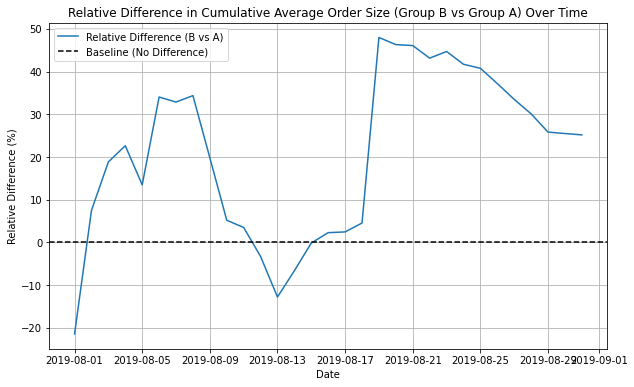

In [30]:
# Plotting the relative difference in cumulative average order size
plt.figure(figsize=(10, 6))
plt.plot(pivot_df.index, pivot_df['relative_difference'], label='Relative Difference (B vs A)')
plt.xlabel('Date')
plt.ylabel('Relative Difference (%)')
plt.title('Relative Difference in Cumulative Average Order Size (Group B vs Group A) Over Time')
plt.axhline(y=0, color='black', linestyle='--', label='Baseline (No Difference)')
plt.legend()
plt.grid(True)
plt.show()

 ##### Make conclusions and conjectures.

 - The relative difference in cumulative average order size indicates that Group B above the baseline points is mosltly always more than Group A below the baseline points
 - Group B performs better in cumulative average orders

#### Calculate each group's conversion rate as the ratio of orders to the number of visits for each day. Plot the daily conversion rates of the two groups and describe the difference.

In [31]:
# Convert 'date' columns to datetime type
df_order['date'] = pd.to_datetime(df_order['date'])
df_visits['date'] = pd.to_datetime(df_visits['date'])

# Merge dataframes on date and group
df_merged = pd.merge(df_order, df_visits, on=['date', 'group'], how='left')

# Calculate daily conversion rates for each group
df_merged['conversion_rate'] = df_merged['transaction_id'] / df_merged['visits']

In [32]:
# Groups average conversion rates
group_conversion_rates = df_merged.groupby('group')['conversion_rate'].mean().reset_index()
print(group_conversion_rates)

  group  conversion_rate
0     A     3.633943e+06
1     B     3.672116e+06


In [33]:
group_date_conversion_rates = df_merged.groupby(['date', 'group'])['conversion_rate'].mean().reset_index()
print(group_date_conversion_rates)

         date group  conversion_rate
0  2019-08-01     A     2.616273e+06
1  2019-08-01     B     3.609424e+06
2  2019-08-02     A     3.562158e+06
3  2019-08-02     B     2.861185e+06
4  2019-08-03     A     3.293633e+06
..        ...   ...              ...
57 2019-08-29     B     4.435018e+06
58 2019-08-30     A     5.471772e+06
59 2019-08-30     B     3.546479e+06
60 2019-08-31     A     3.247189e+06
61 2019-08-31     B     3.615946e+06

[62 rows x 3 columns]


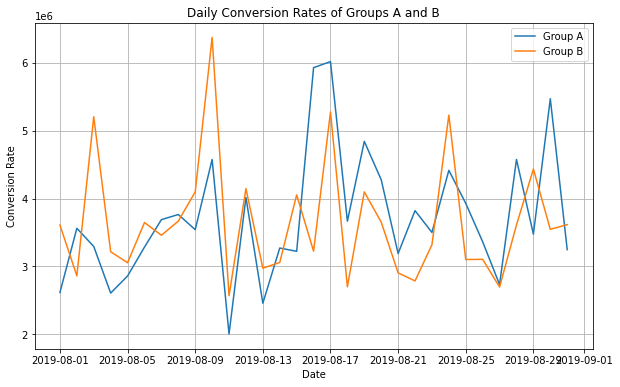

In [34]:
# Pivot the data for easier plotting
pivot_df = df_merged.pivot_table(index='date', columns='group', values='conversion_rate')

# Plotting the daily conversion rates of the two groups
plt.figure(figsize=(10, 6))
plt.plot(pivot_df.index, pivot_df['A'], label='Group A')
plt.plot(pivot_df.index, pivot_df['B'], label='Group B')
plt.xlabel('Date')
plt.ylabel('Conversion Rate')
plt.title('Daily Conversion Rates of Groups A and B')
plt.legend()
plt.grid(True)
plt.show()

#####  Draw conclusions and make conjectures.

- The conversion rates for the Groups A & B carry  similar trends 
- One can conclude that the conversion rates for both groups are affected by the same thing
    - For both groups the orders made are dependance on the number of visits for each day
    - The more the visits the more the orders

####  Plot a scatter chart of the number of orders per user. 

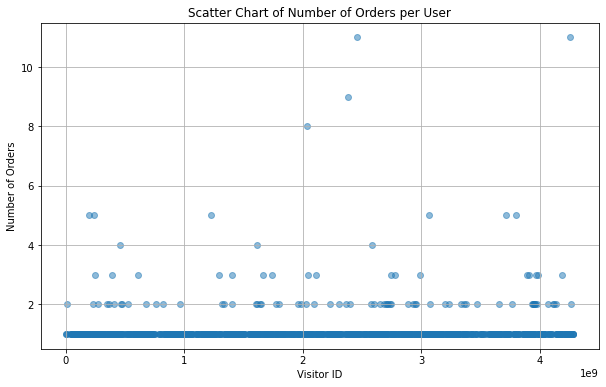

In [35]:
# Calculate the number of orders per user
orders_per_user = df_order.groupby('visitor_id')['transaction_id'].count().reset_index()
orders_per_user.columns = ['visitor_id', 'orders']

# Plotting the scatter chart
plt.figure(figsize=(10, 6))
plt.scatter(orders_per_user['visitor_id'], orders_per_user['orders'], alpha=0.5)
plt.xlabel('Visitor ID')
plt.ylabel('Number of Orders')
plt.title('Scatter Chart of Number of Orders per User')
plt.grid(True)
plt.show()

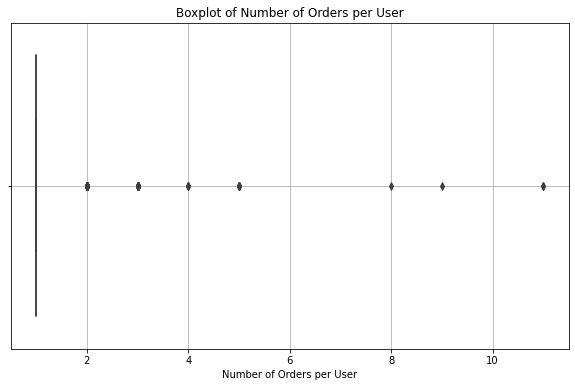

In [36]:
# Plot on Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=orders_per_user['orders'])
plt.xlabel('Number of Orders per User')
plt.title('Boxplot of Number of Orders per User')
plt.grid(True)
plt.show()

In [37]:
# Summary statistics for the 'orders' column
orders_summary = orders_per_user['orders'].describe()

print(orders_summary)

count    1031.000000
mean        1.161009
std         0.724919
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        11.000000
Name: orders, dtype: float64


#####  Make conclusionsand conjectures.

- Generally there is 1 order per user 
- However there are exeptions where user order more than 1 item but never more than 12

#### Calculate the 95th and 99th percentiles for the number of orders per user. Define the point at which a data point becomes an anomaly.

In [38]:
# Calculate the number of orders per user
orders_per_user = df_order.groupby('visitor_id')['transaction_id'].count().reset_index()
orders_per_user.columns = ['visitorId', 'orders']

# Calculate percentiles
percentiles = [95, 99]
percentile_values = np.percentile(orders_per_user['orders'], percentiles)

# Define the point at which a data point becomes an anomaly
anomaly_threshold_95th = percentile_values[0]
anomaly_threshold_99th = percentile_values[1]

# Print the percentile values and anomaly thresholds
print(f"95th Percentile: {percentile_values[0]} orders")
print(f"99th Percentile: {percentile_values[1]} orders")
print(f"Anomaly Threshold (95th Percentile): {anomaly_threshold_95th} orders")
print(f"Anomaly Threshold (99th Percentile): {anomaly_threshold_99th} orders")

# Identify anomalies
anomalies_95th = orders_per_user[orders_per_user['orders'] > anomaly_threshold_95th]
anomalies_99th = orders_per_user[orders_per_user['orders'] > anomaly_threshold_99th]

# Print the number of anomalies
print(f"Number of Anomalies (95th Percentile): {len(anomalies_95th)} users")
print(f"Number of Anomalies (99th Percentile): {len(anomalies_99th)} users")

95th Percentile: 2.0 orders
99th Percentile: 4.0 orders
Anomaly Threshold (95th Percentile): 2.0 orders
Anomaly Threshold (99th Percentile): 4.0 orders
Number of Anomalies (95th Percentile): 30 users
Number of Anomalies (99th Percentile): 10 users


####  Plot a scatter chart of order prices.

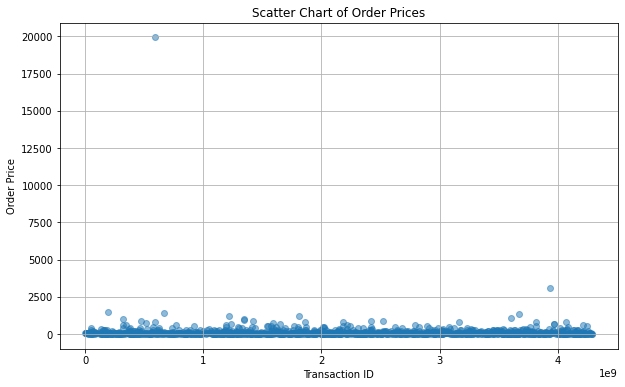

In [39]:
# Plotting the scatter chart for Order Pirces
plt.figure(figsize=(10, 6))
plt.scatter(df_order['transaction_id'], df_order['revenue'], alpha=0.5)
plt.xlabel('Transaction ID')
plt.ylabel('Order Price')
plt.title('Scatter Chart of Order Prices')
plt.grid(True)
plt.show()

#####  Make conclusions and conjectures.

* Anomalies start to occur in the 
    - Anomaly Threshold (95th Percentile) 
    - when there are 2.0 orders and
    - 30 users

* and in the Anomaly Threshold (99th Percentile)
    - when there are 4.0 orders and
    - 10 users

#### Calculate the 95th and 99th percentiles of order prices. Define the point at which a data point becomes an anomaly.

In [40]:
# Calculate percentiles
percentiles = [95, 99]
percentile_values = np.percentile(df_order['revenue'], percentiles)

# Define the point at which a data point becomes an anomaly
anomaly_threshold_95th = percentile_values[0]
anomaly_threshold_99th = percentile_values[1]

# Print the percentile values and anomaly thresholds
print(f"95th Percentile: ${percentile_values[0]:.2f}")
print(f"99th Percentile: ${percentile_values[1]:.2f}")
print(f"Anomaly Threshold (95th Percentile): ${anomaly_threshold_95th:.2f}")
print(f"Anomaly Threshold (99th Percentile): ${anomaly_threshold_99th:.2f}")

# Identify anomalies
anomalies_95th = df_order[df_order['revenue'] > anomaly_threshold_95th]
anomalies_99th = df_order[df_order['revenue'] > anomaly_threshold_99th]

# Print the number of anomalies
print(f"Number of Anomalies (95th Percentile): {len(anomalies_95th)} orders")
print(f"Number of Anomalies (99th Percentile): {len(anomalies_99th)} orders")

95th Percentile: $435.54
99th Percentile: $900.90
Anomaly Threshold (95th Percentile): $435.54
Anomaly Threshold (99th Percentile): $900.90
Number of Anomalies (95th Percentile): 60 orders
Number of Anomalies (99th Percentile): 12 orders


####  Find the statistical significance of the difference in conversion between the groups using the raw data. 

**Mann-Whitney U statistic**
* Measures  the difference between two independent samples.
* The U statistic helps determine if one group of the sample has higher or lower values than the other
* it is used with the p-value
    * if the p-value is below the significance level reject the null hypothesis,
    * if the p-value is above the significance level accept the null hypothesis
    * In the context of conversion rates between groups A and B:
        * Null Hypothesis (H0): There is no difference in conversion rates between groups A and B.
        * Alternative Hypothesis (H1): There is a difference in conversion rates between groups A and B.

In [41]:
# Merge dataframes on date and group
df_merged = pd.merge(df_order, df_visits, on=['date', 'group'], how='left')

# Calculate daily conversion rates for each group
df_merged['conversion_rate'] = df_merged['transaction_id'] / df_merged['visits']

# Extract conversion data for each group
conversion_group_A = df_merged[df_merged['group'] == 'A']['conversion_rate']
conversion_group_B = df_merged[df_merged['group'] == 'B']['conversion_rate']

# Perform Mann-Whitney U test
statistic, p_value = mannwhitneyu(conversion_group_A, conversion_group_B)

# Print results
print(f"Mann-Whitney U statistic: {statistic}")
print(f"P-value: {p_value}")

# Determine statistical significance
alpha = 0.05
if p_value < alpha:
    print("The difference in conversion between the groups is statistically significant.")
else:
    print("There is no statistically significant difference in conversion between the groups.")

Mann-Whitney U statistic: 176424.0
P-value: 0.760878564669322
There is no statistically significant difference in conversion between the groups.


#####  Make conclusions and conjectures.

The diffrences in the conversion rated of group A & B is not big or statistically significant to make a conclution on the conversion rate. In a sence the convertion rate is similar and they have a similar trend.

####  Find the statistical significance of the difference in average order size between the groups using the raw data. 

In [42]:
# Create grouping
group_A = df_order[df_order['group'] == 'A']['revenue']
group_B = df_order[df_order['group'] == 'B']['revenue']

# Perform two-sample t-test
t_stat, p_value = ttest_ind(group_A, group_B, equal_var=False)

# Print results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Determine statistical significance
alpha = 0.05
if p_value < alpha:
    print("The difference in average order size between the groups is statistically significant.")
else:
    print("There is no statistically significant difference in average order size between the groups.")

T-statistic: -0.88861933365294
P-value: 0.3745072295652421
There is no statistically significant difference in average order size between the groups.


##### Make conclusions and conjectures.

The diffrences in the average order size of group A & B is not big or statistically significant to make a conclution on the conversion rate. In a sence the average order size is similar and they have a similar trend.

####  Find the statistical significance of the difference in conversion between the groups using the filtered data. 

In [43]:
# Filter data
start_date = '2019-08-01'
end_date = '2019-08-31'
df_filtered = df_order[(df_order['date'] >= start_date) & (df_order['date'] <= end_date)]

#display filtered df
df_filtered

,transaction_id,visitor_id,date,revenue,group,cumulative_revenue,cumulative_orders,cumulative_avg_order_size
168,2065527789,1581167209,2019-08-01,30.4,A,30.4,1,30.400000
170,617930325,2785040378,2019-08-01,55.8,A,86.2,2,43.100000
171,2153842875,876081193,2019-08-01,55.4,A,141.6,3,47.200000
169,3588515863,1737494355,2019-08-01,30.8,A,172.4,4,43.100000
155,891673177,572335325,2019-08-01,60.8,A,233.2,5,46.640000
...,...,...,...,...,...,...,...,...
958,1207636128,3640080856,2019-08-31,55.2,A,64399.1,556,115.825719
957,3759988715,1762249948,2019-08-31,80.5,B,92764.9,638,145.399530
995,3465107905,2075883701,2019-08-31,45.2,B,92810.1,639,145.242723
1014,3784371772,551106609,2019-08-31,155.8,A,64554.9,557,115.897487


In [44]:
# Calculate the total number of orders for each group
total_orders = df_filtered.groupby('group')['cumulative_orders'].max()

# Calculate the total number of visitors for each group
total_visitors = df_filtered.groupby('group')['cumulative_orders'].count()

# Calculate the conversion rate for each group
conversion_rate = (total_orders / total_visitors) * 100

# Display the conversion rates
print("Conversion Rates:")
print(conversion_rate)

Conversion Rates:
group
A    100.0
B    100.0
Name: cumulative_orders, dtype: float64


In [45]:
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(df_filtered['group'], df_filtered['cumulative_orders'])

# Perform the chi-squared test
chi2, p, _, _ = chi2_contingency(contingency_table)

# Display the results
print(f"Chi-squared value: {chi2}")
print(f"P-value: {p}")

# Check for significance (common significance level is 0.05)
if p < 0.05:
    print("The difference in conversion between the groups is statistically significant.")
else:
    print("There is no significant difference in conversion between the groups.")


Chi-squared value: 77.61796875
P-value: 1.0
There is no significant difference in conversion between the groups.


##### Make conclusions and conjectures.

There is no significant difference in conversion between the groups.

####  Find the statistical significance of the difference in average order size between the groups using the filtered data.

In [46]:
from scipy.stats import ttest_ind

# Extract data for each group
group_a_orders = df_filtered[df_filtered['group'] == 'A']['cumulative_avg_order_size']
group_b_orders = df_filtered[df_filtered['group'] == 'B']['cumulative_avg_order_size']

# Perform the t-test
t_statistic, p_value = ttest_ind(group_a_orders, group_b_orders, equal_var=False)

# Display the results
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Check for significance (common significance level is 0.05)
if p_value < 0.05:
    print("The difference in average order size between the groups is statistically significant.")
else:
    print("There is no significant difference in average order size between the groups.")


T-statistic: -17.07546351170862
P-value: 1.0551113863787922e-57
The difference in average order size between the groups is statistically significant.


#####  Make conclusions and conjectures.

The difference in average order size between the groups is statistically significant.

####   Make a decision based on the test results. The possible decisions are:
Stop the test, conclude that there is no difference between the groups.


There are little statistical diffrences between the groups and their behaviour mirrors e